In [55]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import seaborn
import shap

In [2]:
# Импорт набора даных (набор включает в себя очищенный от мусора и выбросов в данных, а также поля, которые остались после процедуры отбора признаков)
data_second_model = pd.read_csv(r'C:\Data_P\GitHub\data_second_january_2021_model.csv')

In [3]:
data_second_model

,price,lat,lng,type_apartment,renovation,square_total,built_year,type_house,floor_type,playground,sportsground,electrical_type,hot_water_type,gas_type,ventilation_type,drainage_type,floor_house,floor_flat
0,12999000,55.568924,37.574642,Вторичка,Косметический,72.0,1991.0,Панельный,Железобетонные,Есть,Отсутствует,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Отсутствует,Вытяжная вентиляция,Внутренние водостоки,17.0,12.0
1,15000000,55.653390,37.426393,Вторичка,Евроремонт,67.0,2016.0,Монолитный,Железобетонные,Есть,Есть,Центральное,Закрытая с приготовлением горячей воды на ИТП,Отсутствует,Приточно-вытяжная вентиляция,Внутренние водостоки,12.0,8.0
2,14800000,55.590267,37.595869,Вторичка,Евроремонт,73.0,1993.0,Панельный,Железобетонные,Есть,Отсутствует,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Отсутствует,Приточно-вытяжная вентиляция,Внутренние водостоки,17.0,4.0
3,60000000,55.733802,37.438906,Вторичка,Евроремонт,237.0,1998.0,Монолитный,Железобетонные,Есть,Есть,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Отсутствует,Приточно-вытяжная вентиляция,Внутренние водостоки,7.0,6.0
4,23800000,55.784303,37.562775,Вторичка,Без ремонта,73.7,2018.0,Монолитный,Железобетонные,Есть,Есть,Центральное,Открытая с отбором сетевой воды на горячее вод...,Отсутствует,Приточно-вытяжная вентиляция,Смешанные,19.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5075,14200000,55.863469,37.559523,Вторичка,Евроремонт,58.8,2016.0,Кирпичный,Железобетонные,Отсутствует,Отсутствует,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Отсутствует,Приточно-вытяжная вентиляция,Внутренние водостоки,18.0,11.0
5076,7600000,55.721610,37.898799,Вторичка,Косметический,38.0,2006.0,Монолитный,Железобетонные,Есть,Есть,Центральное,Открытая с отбором сетевой воды на горячее вод...,Отсутствует,Приточно-вытяжная вентиляция,Внутренние водостоки,11.0,7.0
5077,13900000,55.677935,37.531622,Вторичка,Косметический,49.0,1959.0,Кирпичный,Железобетонные,Есть,Есть,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Вытяжная вентиляция,Наружные водостоки,8.0,8.0
5078,169914109,55.723237,37.527903,Вторичка,Дизайнерский,160.0,2011.0,Монолитный,Железобетонные,Есть,Есть,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Отсутствует,Приточно-вытяжная вентиляция,Внутренние водостоки,53.0,47.0


## Random Forest

### 1) Формирование обучающей и отложенной выборки

In [4]:
## Перемешивание исходной выборки
data_second_model = data_second_model.sample(frac=1)
data_second_model.reset_index(drop=True, inplace=True)

In [5]:
## Формировние выборок
# Обучающая выборка
data_second_train = data_second_model.loc[0:len(data_second_model)*2/3, :].copy()
data_second_train.reset_index(drop=True, inplace=True)
# Отложенная выборка
data_second_test = data_second_model.loc[len(data_second_model)*2/3:, :].copy()
data_second_test.reset_index(drop=True, inplace=True)

## Формирование матриц целевой переменной y и независимых переменных X
# Обучающая выборка
y_train = pd.Series(data_second_train['price'])
X_train = data_second_train.iloc[:, 1:]
# Отложенная выборка
y_test = pd.Series(data_second_test['price'])
X_test = data_second_test.iloc[:, 1:]

In [6]:
## Применение горячего кодирования к категориальным переменным в матрицах X (используется горячее кодирвоание, ибо все категориальные переменные являются неупорядоченными)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [7]:
X_train.columns

Index(['lat', 'lng', 'square_total', 'built_year', 'floor_house', 'floor_flat',
       'type_apartment_Вторичка', 'type_apartment_Вторичка Апартаменты',
       'type_apartment_Вторичка Пентхаус', 'renovation_Без ремонта',
       'renovation_Дизайнерский', 'renovation_Евроремонт',
       'renovation_Косметический', 'type_house_Блочный',
       'type_house_Кирпичный', 'type_house_Монолитно кирпичный',
       'type_house_Монолитный', 'type_house_Панельный',
       'floor_type_Деревянные', 'floor_type_Железобетонные', 'playground_Есть',
       'playground_Отсутствует', 'sportsground_Есть',
       'sportsground_Отсутствует', 'electrical_type_Комбинированное',
       'electrical_type_Центральное',
       'hot_water_type_Автономная котельная (крышная, встроенно-пристроенная)',
       'hot_water_type_Закрытая с приготовлением горячей воды на ИТП',
       'hot_water_type_Закрытая с приготовлением горячей воды на ЦТП',
       'hot_water_type_Квартирное (квартирный котел)',
       'hot_water_type

In [8]:
X_test.columns

Index(['lat', 'lng', 'square_total', 'built_year', 'floor_house', 'floor_flat',
       'type_apartment_Вторичка', 'type_apartment_Вторичка Апартаменты',
       'type_apartment_Вторичка Пентхаус', 'renovation_Без ремонта',
       'renovation_Дизайнерский', 'renovation_Евроремонт',
       'renovation_Косметический', 'type_house_Блочный',
       'type_house_Кирпичный', 'type_house_Монолитно кирпичный',
       'type_house_Монолитный', 'type_house_Панельный',
       'floor_type_Деревянные', 'floor_type_Железобетонные', 'playground_Есть',
       'playground_Отсутствует', 'sportsground_Есть',
       'sportsground_Отсутствует', 'electrical_type_Комбинированное',
       'electrical_type_Центральное',
       'hot_water_type_Автономная котельная (крышная, встроенно-пристроенная)',
       'hot_water_type_Закрытая с приготовлением горячей воды на ИТП',
       'hot_water_type_Закрытая с приготовлением горячей воды на ЦТП',
       'hot_water_type_Квартирное (квартирный котел)',
       'hot_water_type

In [9]:
len(X_train.columns)

40

In [10]:
len(X_test.columns)

40

### Оптимизация Random Forest по гиперпараметрам с помощью GridSearchCV

Для Random Forest наиболее важными гиперпараметрами являются количество деревьев и число признаков для расщепления. Кроме того, через глубину деревьев можно решить проблему переобучения (тем не менее, для случайного леса она не стоит так остро). Для критерия качества была выбрана средняя абсолютная ошибка в процентах, поскольку для задачи оценки стоимости квартир это наиболее подходящая мера измерения качества (кроме того, она более устойчива к выбросам в отличие от RMSE и R2), поскольку обычно оценщиков интересует относительная погрешность. Кроме того, так как в рамках данной задачи как недооценка, так и переоценка стоимости имеют одинаковую важность, то вполне уместно использовать симметричную метрику.

In [11]:
## Задаем сетку и настройки, по которым будет осуществляться поиск гиперпараметров
# Алгоритм
model = RandomForestRegressor()
# Параметры кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# Сетка гиперпараметров
parametrs = { 'n_estimators': [50, 100, 150],
              'max_features': [5, 10, 15, 20, 25, 30, 35],
              'max_depth': [3, 6, 10, 20, 40]}
# Подбор гиперпараметров
grid = GridSearchCV(model, cv = cv, param_grid = parametrs, scoring = 'neg_mean_absolute_percentage_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 6, 10, 20, 40],
                         'max_features': [5, 10, 15, 20, 25, 30, 35],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_absolute_percentage_error')

In [12]:
# Значения гиперпараметров, обеспечивающих наилучшее качество на обучающей выборке с кросс-валидацией
grid.best_params_

{'max_depth': 40, 'max_features': 35, 'n_estimators': 150}

Стоит отметить, что при прочих равных условиях качество Random Forest будет расти при увеличении количества деревьев:

[Text(0.5, 0, 'n_estimators'), Text(0, 0.5, 'MAPE')]

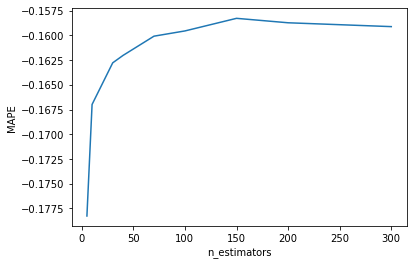

In [13]:
# Формируем список, состоящий из значений MAPE для различного количества деревьев в Random Forest
cv = KFold(n_splits=5, shuffle=True, random_state=1)
list_MAPE_n_estimators = []
for i in [5, 10, 30, 40, 70, 100, 150, 200, 300]:
    model = RandomForestRegressor(n_estimators = i)
    model.fit(X_train, y_train)
    score_i = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_percentage_error").mean()
    list_MAPE_n_estimators.append(score_i)
# DataFrame с оценками и количеством деревьев
RF_score = pd.DataFrame()
RF_score['MAPE'] = list_MAPE_n_estimators
RF_score['n_estimators'] = [5, 10, 30, 40, 70, 100, 150, 200, 300]
# Строим график
ax = seaborn.lineplot(data=RF_score, x='n_estimators', y='MAPE')
ax.set(xlabel='n_estimators', ylabel='MAPE')

Тем не менее видно, что в даном случае наилучшее качество достигается, когда количество деревьев принимает значение около 150 (если остальные гиперпараметры установлены по умолчанию). Вполне возможно, что это обусловлено используемой метрикой качества (В данном случае MAPE является отрицательной из-за особенностей расчета библиотеки при осуществлении кросс-валидации. На самом деле данные значения нужно умножить еще на -1).

Более тонкая настройка гиперпараметров показала, что наилучшее качество, измеренное на тестовой выборке, Random Forest достигает при следующим значениях гиперпараметров:
n_estimators = 181,
max_features = 27,
max_depth - не ограничивать.

### Оценка обобщающей способности оптимизированного Random Forest 

In [18]:
model = RandomForestRegressor(n_estimators = 181, max_features = 27)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
MAPE = mean_absolute_percentage_error(y_true = y_test, y_pred = y_predict)

In [19]:
MAPE

0.15199131235599914

Тем не менее, интересно посмотреть, какое значение различных метрик качества обученного алгоритма достигается для того или иного ценового сегмента отложенной выборки.

In [46]:
# Сортировка тестовой выборки по цене
data_second_test = data_second_test.sort_values(by='price')
data_second_test.reset_index(drop=True, inplace=True)
y_test = pd.DataFrame(data_second_test['price'], columns = ['price'])
X_test = data_second_test.iloc[:, 1:]
X_test = pd.get_dummies(X_test)
# Формируем таблицу оценок
RF_score_segment = pd.DataFrame(columns = ['segment', 'RMSE', 'MAE', 'MAPE'])
# Оценка обобщающей способности
for i in range(0, 5):
    print(i)
    if i < 4:
        y_test_i = y_test.loc[339*i:339*(i+1), :].copy()
        X_test_i = X_test.loc[339*i:339*(i+1), :].copy()
        y_predict_i = model.predict(X_test_i)
        RMSE_i = mean_squared_error(y_true = y_test_i, y_pred = y_predict_i, squared = False)
        MAE_i = mean_absolute_error(y_true = y_test_i, y_pred = y_predict_i)
        MAPE_i = mean_absolute_percentage_error(y_true = y_test_i, y_pred = y_predict_i)
        min_price_i = min(y_test_i.loc[:, 'price'])
        max_price_i = max(y_test_i.loc[:, 'price'])
        RF_score_segment.loc[i, ['segment', 'RMSE', 'MAE', 'MAPE']] = [str(min_price_i) + ' - ' + str(max_price_i),
                                                                      RMSE_i, MAE_i, MAPE_i]
    else:
        y_test_i = y_test.loc[339*4:, :].copy()
        X_test_i = X_test.loc[339*4:, :].copy()
        y_predict_i = model.predict(X_test_i)
        RMSE_i = mean_squared_error(y_true = y_test_i, y_pred = y_predict_i, squared = False)
        MAE_i = mean_absolute_error(y_true = y_test_i, y_pred = y_predict_i)
        MAPE_i = mean_absolute_percentage_error(y_true = y_test_i, y_pred = y_predict_i)
        min_price_i = min(y_test_i.loc[:, 'price'])
        max_price_i = max(y_test_i.loc[:, 'price'])
        RF_score_segment.loc[i, ['segment', 'RMSE', 'MAE', 'MAPE']] = [str(min_price_i) + ' - ' + str(max_price_i),
                                                                      RMSE_i, MAE_i, MAPE_i]


0
1
2
3
4


In [47]:
RF_score_segment

,segment,RMSE,MAE,MAPE
0,4350000 - 10500000,1268996.870204,891730.007724,0.104747
1,10500000 - 13800000,2083037.785602,1301276.311133,0.10758
2,13800000 - 19500000,3244873.816026,1772731.866932,0.106634
3,19500000 - 35000000,9081629.458626,5324449.709491,0.204694
4,35000000 - 960358341,39943971.922174,23536438.493095,0.236378


Видно, что для первых трех ценовых сегментов средняя абсолютная ошибка в процентах принимает значение около 10,5%. Вместе с тем, по мере перехода к более высоким сегментам ошибка начинает расти. Вполне возможно, что это обусловлено большим разбросом цен внутри сегмента, пространственной неоднородностью, а также совершенно другими механизмами ценообразования, в основе которого лежат факторы, отсутствующие в данном наборе данных.

In [48]:
list_error = []
y_test_predict = model.predict(X_test)
for i in range(0, len(X_test)):
    error_i = abs(y_test.loc[i, 'price'] - y_test_predict[i]) / y_test.loc[i, 'price']
    list_error.append(error_i)

[Text(0, 0.5, 'Частота'),
 Text(0.5, 0, 'Абсолютная ошибка, %'),
 Text(0.5, 1.0, '')]

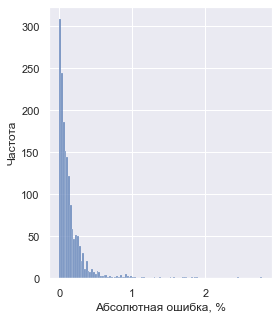

In [51]:
seaborn.set(font_scale = 1)
seaborn.mpl.rc('figure', figsize = (4,5))
seaborn.histplot(list_error).set(ylabel='Частота', xlabel='Абсолютная ошибка, %', title = '')

Распределение абсолютных ошибок в процентах показывает, что имеются и довольно большие расхождения (более 200%). Скорее всего это из-за неудаленных "мусорных" наблюдений или из-за уникальных объектов недвижимости. Тем не менее, по подавляющему большинству квартир абсолютное отклонение составляет не более 15%.

### Интерпретация результатов Random Forest с помощью вектора Шепли

In [56]:
# Вычисление вектора Шепли
shap_values = shap.TreeExplainer(model).shap_values(X_train)

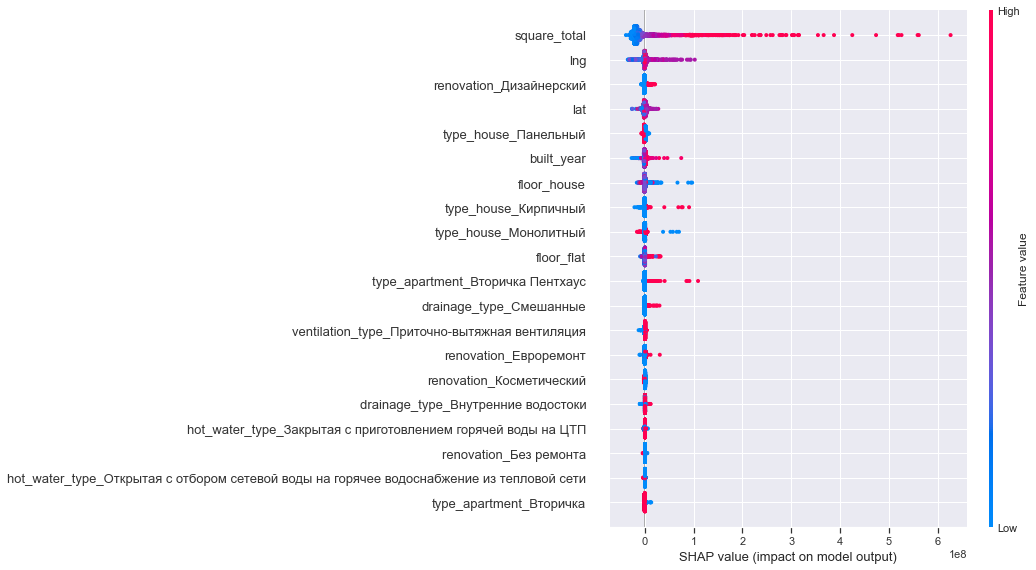

In [57]:
# Сводный график
shap.summary_plot(shap_values, X_train)

На графике представлены наиболее значимые факторы, влияюшие на цену квартиры (чем выше расположено наименование фактора или его значения, тем более значимым он является). Так, общая площадь является самым значимым.

Среди числовых переменных положительное влияние оказывают такие факторы, как общая площадь, год постройки, этаж квартиры. Дизайнерский ремонт и евроремонт также оказывают положительное влияние. Кирпичная технология строительства дома, в котором расположена квартира, тоже увеличивает стоимость квартиры, как и то, что квартира является пентахусом.

Отрицательное влияние на цену оказывает панельная технология строительства дома, в котором располагается квартира и отсутствие ремонта.

Вместе с тем, судить о характере зависимости по данному графику невозможно. Кроме того, для ряда факторов не удалось выявить даже направление влияния на цену (например, по географическим координатам). Это указывает на довольно сложные существующие взаимосвязи в данных (в случае географических координат, на сложную пространственную неоднородность рынка жилья Москвы).